
# **Deep Learning Fundamentals Assignment 2**
# **CNNs for image classification**
## **Suhirtha Ravindran a1903155**

# 1. Importing packages

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from tensorflow.keras import layers, Model
from torchvision import models
import itertools

# 2. Reading the dataset CIFAR-10

In [2]:
# Setup

# Set seed
seed=50
torch.cuda.manual_seed_all(seed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Full Training Data
full_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Train-Validation (80-20) split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

# Data Loaders - train, validation and test
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)
test_size = len(testset)

print("Train-size: ", train_size)
print("Validation-size: ", val_size)
print("Test-size: ", test_size)

# Checking class labels in the dataset
classes = full_trainset.classes
print("Classes:", classes)

# Checking the shape and type of the dataset
images, labels = next(iter(trainloader))
print(f"Image batch dimensions: {images.size()}")
print(f"Label batch dimensions: {labels.size()}")

Files already downloaded and verified
Files already downloaded and verified
Train-size:  40000
Validation-size:  10000
Test-size:  10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image batch dimensions: torch.Size([64, 3, 32, 32])
Label batch dimensions: torch.Size([64])


## 2.1 Visualising a sample batch of the dataset

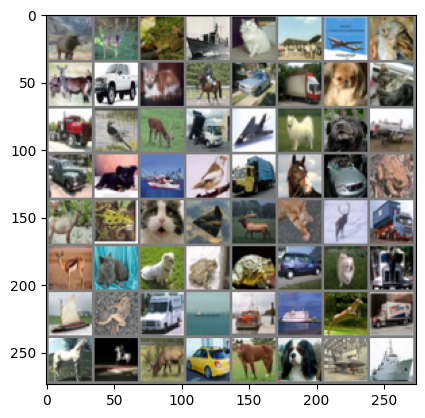

In [4]:
def imshow(img):
    # De-normalising
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# 3. Simple CNN

## 3.1 Simple CNN without hyper parameter tuning

Epoch [1/10] - Train Loss: 1.7124, Train Acc: 36.12% - Val Loss: 1.2927, Val Acc: 54.35%
Epoch [2/10] - Train Loss: 1.3055, Train Acc: 53.40% - Val Loss: 1.0948, Val Acc: 60.96%
Epoch [3/10] - Train Loss: 1.1270, Train Acc: 60.60% - Val Loss: 0.9900, Val Acc: 64.97%
Epoch [4/10] - Train Loss: 0.9921, Train Acc: 65.84% - Val Loss: 0.8701, Val Acc: 69.59%
Epoch [5/10] - Train Loss: 0.9031, Train Acc: 68.90% - Val Loss: 0.8459, Val Acc: 70.17%
Epoch [6/10] - Train Loss: 0.8254, Train Acc: 71.92% - Val Loss: 0.8068, Val Acc: 71.95%
Epoch [7/10] - Train Loss: 0.7607, Train Acc: 74.08% - Val Loss: 0.7712, Val Acc: 73.23%
Epoch [8/10] - Train Loss: 0.7074, Train Acc: 75.73% - Val Loss: 0.7622, Val Acc: 73.98%
Epoch [9/10] - Train Loss: 0.6578, Train Acc: 77.39% - Val Loss: 0.7640, Val Acc: 74.29%
Epoch [10/10] - Train Loss: 0.6166, Train Acc: 78.78% - Val Loss: 0.7817, Val Acc: 74.05%


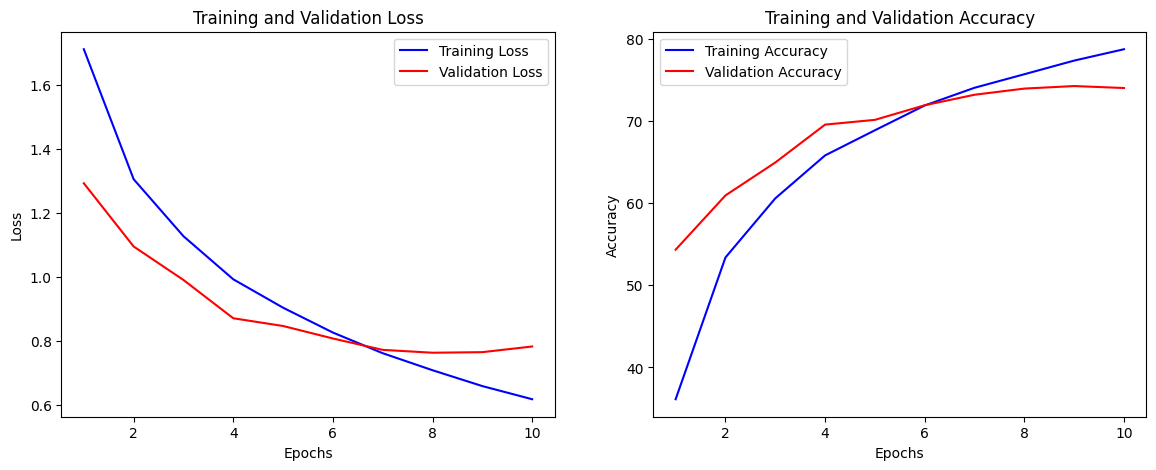

Test Accuracy: 74.29%


In [5]:
# Set seed
random.seed(seed)

# Custome basic or simple CNN
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels=3, Output channels=32
        self.pool1 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels=32, Output channels=64
        self.pool2 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# Input channels=64, Output channels=128
        self.pool3 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        # Convolutional layers with ReLU and pooling
        x = self.pool1(torch.relu(self.conv1(x)))  # Output: [batch_size, 32, 16, 16]
        x = self.pool2(torch.relu(self.conv2(x)))  # Output: [batch_size, 64, 8, 8]
        x = self.pool3(torch.relu(self.conv3(x)))  # Output: [batch_size, 128, 4, 4]

        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with Dropout
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.fc3(x)  # Output: [batch_size, 10]
        return x

# Loss function and Optimizer
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
num_epochs = 10
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze())  # labels.shape: [batch_size, 1]

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels.squeeze()).sum().item()

    epoch_val_loss = val_loss / len(valloader)
    epoch_val_acc = 100 * val_correct / val_total
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Plotting training and validation metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels.squeeze()).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

## 3.2 Evaluating the model on a validation set during training

Epoch [1/10] - Train Loss: 1.6928, Train Acc: 36.56% - Val Loss: 1.2655, Val Acc: 54.40%
Epoch [2/10] - Train Loss: 1.2843, Train Acc: 53.78% - Val Loss: 1.0936, Val Acc: 60.40%
Epoch [3/10] - Train Loss: 1.1114, Train Acc: 60.98% - Val Loss: 0.9384, Val Acc: 66.88%
Epoch [4/10] - Train Loss: 0.9954, Train Acc: 65.54% - Val Loss: 0.8803, Val Acc: 69.59%
Epoch [5/10] - Train Loss: 0.8902, Train Acc: 69.33% - Val Loss: 0.8470, Val Acc: 70.28%
Epoch [6/10] - Train Loss: 0.8153, Train Acc: 72.31% - Val Loss: 0.7720, Val Acc: 73.41%
Epoch [7/10] - Train Loss: 0.7503, Train Acc: 74.49% - Val Loss: 0.7959, Val Acc: 72.16%
Epoch [8/10] - Train Loss: 0.6925, Train Acc: 76.28% - Val Loss: 0.7467, Val Acc: 74.43%
Epoch [9/10] - Train Loss: 0.6380, Train Acc: 78.13% - Val Loss: 0.7524, Val Acc: 74.38%
Epoch [10/10] - Train Loss: 0.5987, Train Acc: 79.60% - Val Loss: 0.7486, Val Acc: 75.38%


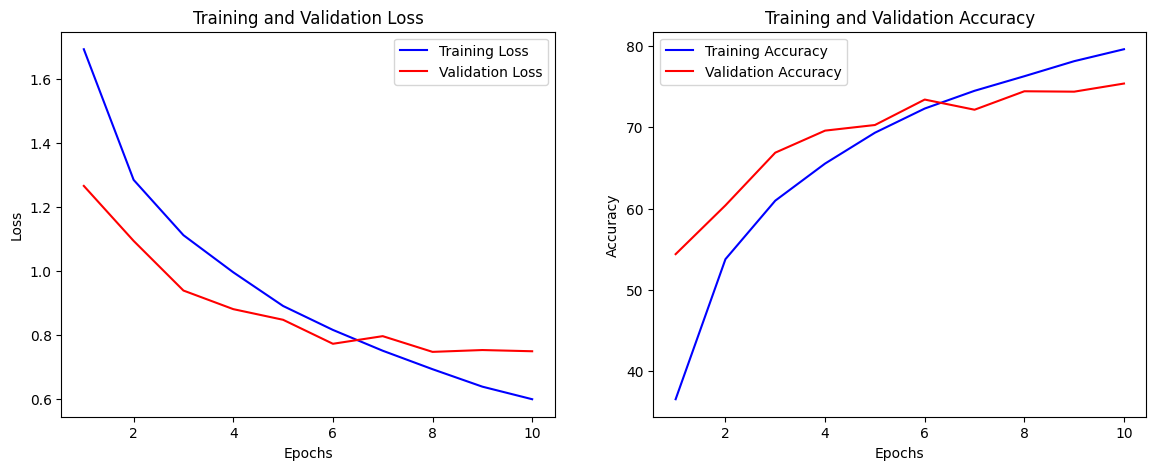

Test Accuracy: 74.61%


In [6]:
# Set seed
random.seed(seed)

# Basic custom CNN model
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels=3, Output channels=32
        self.pool1 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels=32, Output channels=64
        self.pool2 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# Input channels=64, Output channels=128
        self.pool3 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool1(torch.relu(self.conv1(x)))  # Output: [batch_size, 32, 16, 16]
        x = self.pool2(torch.relu(self.conv2(x)))  # Output: [batch_size, 64, 8, 8]
        x = self.pool3(torch.relu(self.conv3(x)))  # Output: [batch_size, 128, 4, 4]

        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with Dropout
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.fc3(x)  # Output: [batch_size, 10]
        return x

# Loss function and Optimizer
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
num_epochs = 10
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze())  # labels.shape: [batch_size, 1]

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.squeeze()).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100 * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels.squeeze()).sum().item()

    epoch_val_loss = val_loss / len(valloader)
    epoch_val_acc = 100 * val_correct / val_total
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% - "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

# Plotting training and validation metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels.squeeze()).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


## 3.3 Simple CNN with hyper parameter tuning using grid search

Training with LR=0.001, Dropout=0.5, Batch Size=32, Epochs=10
Validation Accuracy: 73.42%
Training with LR=0.001, Dropout=0.5, Batch Size=64, Epochs=10
Validation Accuracy: 74.42%
Training with LR=0.001, Dropout=0.3, Batch Size=32, Epochs=10
Validation Accuracy: 74.48%
Training with LR=0.001, Dropout=0.3, Batch Size=64, Epochs=10
Validation Accuracy: 75.79%
Training with LR=0.0001, Dropout=0.5, Batch Size=32, Epochs=10
Validation Accuracy: 63.75%
Training with LR=0.0001, Dropout=0.5, Batch Size=64, Epochs=10
Validation Accuracy: 60.69%
Training with LR=0.0001, Dropout=0.3, Batch Size=32, Epochs=10
Validation Accuracy: 66.78%
Training with LR=0.0001, Dropout=0.3, Batch Size=64, Epochs=10
Validation Accuracy: 60.35%

Best hyperparameters: {'lr': 0.001, 'dropout_rate': 0.3, 'batch_size': 64, 'num_epochs': 10}
Best validation accuracy: 75.79%


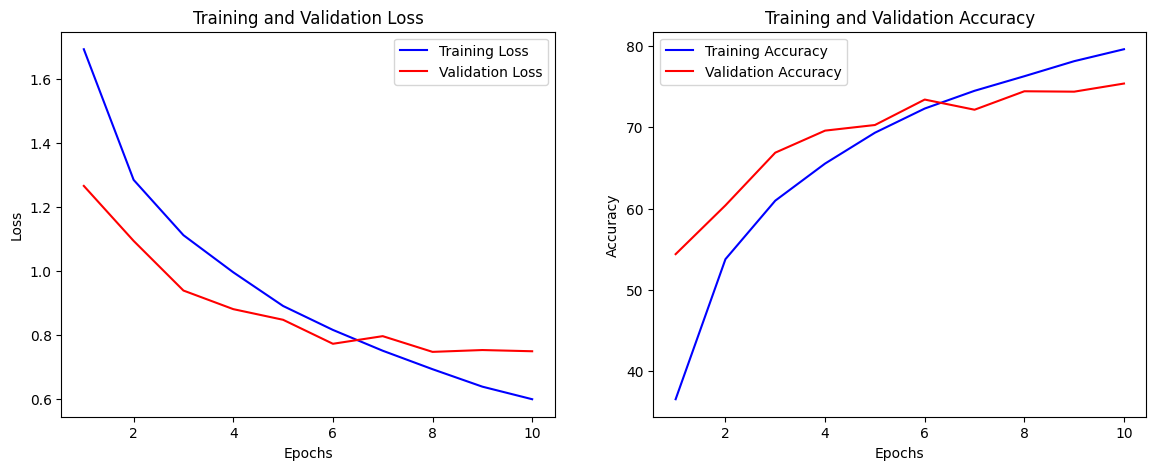

In [7]:
# Set seed
random.seed(seed)


# Define a custom CNN model
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):

        super(CustomCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels=3, Output channels=32
        self.pool1 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Input channels=32, Output channels=64
        self.pool2 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# Input channels=64, Output channels=128
        self.pool3 = nn.MaxPool2d(2, 2)                          # 2x2 Max Pooling

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):

        # Convolutional layers with ReLU and pooling
        x = self.pool1(torch.relu(self.conv1(x)))  # Output: [batch_size, 32, 16, 16]
        x = self.pool2(torch.relu(self.conv2(x)))  # Output: [batch_size, 64, 8, 8]
        x = self.pool3(torch.relu(self.conv3(x)))  # Output: [batch_size, 128, 4, 4]

        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers with Dropout
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        x = self.fc3(x)  # Output: [batch_size, 10]
        return x

# Function for training and evaluation
def train_and_evaluate(lr, batch_size, dropout_rate, num_epochs):
    # Create DataLoader with the specified batch size
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(valset, batch_size=batch_size, shuffle=False)

    # Loss function and Optimizer
    model = CustomCNN(dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(valloader)
        epoch_val_acc = 100 * val_correct / val_total
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

    # Return the final validation accuracy
    return val_acc_history[-1]

# Hyperparameters to tune
learning_rates = [0.001, 0.0001]
dropout_rates = [0.5, 0.3]
batch_sizes = [32, 64]
num_epochs_options = [10]

# Grid search: try all combinations of hyperparameters
best_val_acc = 0
best_params = {}

for lr, dropout_rate, batch_size, num_epochs in itertools.product(learning_rates, dropout_rates, batch_sizes, num_epochs_options):
    print(f"Training with LR={lr}, Dropout={dropout_rate}, Batch Size={batch_size}, Epochs={num_epochs}")
    val_acc = train_and_evaluate(lr, batch_size, dropout_rate, num_epochs)
    print(f"Validation Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = {'lr': lr, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'num_epochs': num_epochs}

print("\nBest hyperparameters:", best_params)
print(f"Best validation accuracy: {best_val_acc:.2f}%")

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 3.4 Resnet-18

In [8]:
# Set seed
random.seed(seed)

# ResNet-18 model with dropout and hyperparameter tuning

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.5):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        out = self.dropout(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, 2, stride=1, dropout_rate=dropout_rate)
        self.layer2 = self._make_layer(64, 128, 2, stride=2, dropout_rate=dropout_rate)
        self.layer3 = self._make_layer(128, 256, 2, stride=2, dropout_rate=dropout_rate)
        self.layer4 = self._make_layer(256, 512, 2, stride=2, dropout_rate=dropout_rate)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride, dropout_rate):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride, dropout_rate))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels, dropout_rate=dropout_rate))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.fc(x)
        return x

# Hyperparameters to be tuned
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
# Stop training if validation loss does not improve for 5 epochs
early_stopping_patience = 5

model = ResNet18(num_classes=10, dropout_rate=dropout_rate).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = model.state_dict()

# Training loop with validation and early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    # If patience counter exceeds early stopping threshold, stop training
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(best_model_wts)

# Testing the best model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Epoch [1/10] - Train Loss: 2.0818, Train Acc: 21.62%, Val Loss: 2.0703, Val Acc: 21.49%
Epoch [2/10] - Train Loss: 1.7524, Train Acc: 31.65%, Val Loss: 1.6447, Val Acc: 37.60%
Epoch [3/10] - Train Loss: 1.5593, Train Acc: 41.58%, Val Loss: 1.3512, Val Acc: 49.55%
Epoch [4/10] - Train Loss: 1.4222, Train Acc: 47.90%, Val Loss: 1.2745, Val Acc: 53.31%
Epoch [5/10] - Train Loss: 1.3200, Train Acc: 53.16%, Val Loss: 1.3479, Val Acc: 53.29%
Epoch [6/10] - Train Loss: 1.2324, Train Acc: 56.81%, Val Loss: 1.0493, Val Acc: 62.94%
Epoch [7/10] - Train Loss: 1.1554, Train Acc: 60.08%, Val Loss: 1.0288, Val Acc: 63.38%
Epoch [8/10] - Train Loss: 1.0989, Train Acc: 62.32%, Val Loss: 0.9717, Val Acc: 66.39%
Epoch [9/10] - Train Loss: 1.0481, Train Acc: 64.17%, Val Loss: 1.0134, Val Acc: 65.36%
Epoch [10/10] - Train Loss: 1.0211, Train Acc: 65.58%, Val Loss: 0.8966, Val Acc: 69.35%
Test Accuracy: 68.70%


## 3.5 EfficientNetLite

In [9]:
# Set seed
random.seed(seed)

# EfficientNet-Lite model (Base model: EfficientNet-B0) with drop out and hyperparameter tuning

class EfficientNetLite(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(EfficientNetLite, self).__init__()

        # Load the pre-trained EfficientNet-B0 model
        self.model = models.efficientnet_b0(pretrained=True)

        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters to be tuned
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping_patience = 5

# Instantiate the model
model = EfficientNetLite(num_classes=10, dropout_rate=dropout_rate).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = model.state_dict()

# Training loop with validation and early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total

    # Print results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping: check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    # If patience counter exceeds early stopping threshold, stop training
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

model.load_state_dict(best_model_wts)

# Testing the best model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 174MB/s]


Epoch [1/10] - Train Loss: 1.1883, Train Acc: 59.38%, Val Loss: 0.7253, Val Acc: 75.47%
Epoch [2/10] - Train Loss: 0.7295, Train Acc: 75.90%, Val Loss: 0.6117, Val Acc: 79.39%
Epoch [3/10] - Train Loss: 0.5870, Train Acc: 80.67%, Val Loss: 0.5515, Val Acc: 81.22%
Epoch [4/10] - Train Loss: 0.5033, Train Acc: 83.44%, Val Loss: 0.5159, Val Acc: 82.51%
Epoch [5/10] - Train Loss: 0.4461, Train Acc: 85.33%, Val Loss: 0.5101, Val Acc: 82.93%
Epoch [6/10] - Train Loss: 0.3984, Train Acc: 86.78%, Val Loss: 0.5513, Val Acc: 81.92%
Epoch [7/10] - Train Loss: 0.3529, Train Acc: 88.26%, Val Loss: 0.5333, Val Acc: 83.19%
Epoch [8/10] - Train Loss: 0.3246, Train Acc: 89.35%, Val Loss: 0.5259, Val Acc: 83.66%
Epoch [9/10] - Train Loss: 0.2935, Train Acc: 90.53%, Val Loss: 0.5156, Val Acc: 84.01%
Epoch [10/10] - Train Loss: 0.2608, Train Acc: 91.27%, Val Loss: 0.5350, Val Acc: 83.47%
Early stopping triggered at epoch 10
Test Accuracy: 82.66%


## 3.6 MobileNetV2

In [10]:
# Set seed
random.seed(seed)

# Define the MobileNetV2 model with dropout and hyperparameter tuning
class MobileNetV2WithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(MobileNetV2WithDropout, self).__init__()

        self.model = models.mobilenet_v2(pretrained=True)

        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters (to be tuned)
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping_patience = 5

model = MobileNetV2WithDropout(num_classes=10, dropout_rate=dropout_rate).to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = model.state_dict()

# Train loop with validation and early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute training loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping: check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    # If patience counter exceeds early stopping threshold, stop training
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Testing the best model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 182MB/s]


Epoch [1/10] - Train Loss: 1.0559, Train Acc: 64.49%, Val Loss: 0.7635, Val Acc: 74.29%
Epoch [2/10] - Train Loss: 0.7745, Train Acc: 74.59%, Val Loss: 0.9572, Val Acc: 70.72%
Epoch [3/10] - Train Loss: 1.0405, Train Acc: 66.64%, Val Loss: 1.5800, Val Acc: 53.43%
Epoch [4/10] - Train Loss: 1.0212, Train Acc: 67.22%, Val Loss: 0.8513, Val Acc: 70.83%
Epoch [5/10] - Train Loss: 1.0461, Train Acc: 66.25%, Val Loss: 1.2020, Val Acc: 59.71%
Epoch [6/10] - Train Loss: 1.3968, Train Acc: 54.23%, Val Loss: 1.2102, Val Acc: 58.56%
Early stopping triggered at epoch 6
Test Accuracy: 56.88%


## 3.7 SqueezeNet

In [11]:
# Set seed
random.seed(seed)

# Define the SqueezeNet model with dropout and hyper parameter tuning
class SqueezeNetWithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(SqueezeNetWithDropout, self).__init__()

        self.model = models.squeezenet1_1(pretrained=True)

        in_features = self.model.classifier[1].in_channels
        self.model.classifier[1] = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(in_features, num_classes, kernel_size=1)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters to be tuned
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping_patience = 5

model = SqueezeNetWithDropout(num_classes=10, dropout_rate=dropout_rate).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = model.state_dict()

# Train loop with validation and early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute train loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total

    # Print results for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping: check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    # If patience counter exceeds early stopping threshold, stop training
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Testing the best model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 159MB/s]


Epoch [1/10] - Train Loss: 2.3205, Train Acc: 10.73%, Val Loss: 2.3027, Val Acc: 9.55%
Epoch [2/10] - Train Loss: 2.3026, Train Acc: 9.74%, Val Loss: 2.3026, Val Acc: 10.73%
Epoch [3/10] - Train Loss: 2.3026, Train Acc: 9.81%, Val Loss: 2.3026, Val Acc: 10.73%
Epoch [4/10] - Train Loss: 2.3026, Train Acc: 9.82%, Val Loss: 2.3026, Val Acc: 10.73%
Epoch [5/10] - Train Loss: 2.3026, Train Acc: 9.82%, Val Loss: 2.3026, Val Acc: 10.73%
Epoch [6/10] - Train Loss: 2.3026, Train Acc: 9.82%, Val Loss: 2.3026, Val Acc: 10.73%
Epoch [7/10] - Train Loss: 2.3026, Train Acc: 9.82%, Val Loss: 2.3026, Val Acc: 10.73%
Early stopping triggered at epoch 7
Test Accuracy: 10.00%


## 3.8 ShuffleNetV2

In [12]:
# Set seed
random.seed(seed)

# Define ShuffleNetV2 with dropout and hyperparameter tuning
class ShuffleNetV2WithDropout(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5):
        super(ShuffleNetV2WithDropout, self).__init__()

        self.model = models.shufflenet_v2_x1_0(pretrained=True)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters to be tuned
learning_rate = 0.001
num_epochs = 10
dropout_rate = 0.5
# Stop training if validation loss doesn't improve for 5 epochs
early_stopping_patience = 5

model = ShuffleNetV2WithDropout(num_classes=10, dropout_rate=dropout_rate).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping
best_val_loss = float('inf')
patience_counter = 0
best_model_wts = model.state_dict()

# Train loop with validation and early stopping
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Train phase
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Compute train loss and accuracy
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(valloader)
    val_acc = 100 * val_correct / val_total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Early stopping: check if validation loss has improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    # If patience counter exceeds early stopping threshold, stop training
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load the best model weights
model.load_state_dict(best_model_wts)

# Testing the best model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 191MB/s]


Epoch [1/10] - Train Loss: 1.1371, Train Acc: 61.80%, Val Loss: 0.7863, Val Acc: 73.14%
Epoch [2/10] - Train Loss: 0.7626, Train Acc: 73.98%, Val Loss: 0.6940, Val Acc: 76.09%
Epoch [3/10] - Train Loss: 0.6412, Train Acc: 77.86%, Val Loss: 0.6884, Val Acc: 75.85%
Epoch [4/10] - Train Loss: 0.5642, Train Acc: 80.31%, Val Loss: 0.6595, Val Acc: 77.26%
Epoch [5/10] - Train Loss: 0.4881, Train Acc: 82.96%, Val Loss: 0.6801, Val Acc: 77.20%
Epoch [6/10] - Train Loss: 0.4426, Train Acc: 84.67%, Val Loss: 0.6752, Val Acc: 77.81%
Epoch [7/10] - Train Loss: 0.3956, Train Acc: 86.34%, Val Loss: 0.6989, Val Acc: 77.42%
Epoch [8/10] - Train Loss: 0.3594, Train Acc: 87.53%, Val Loss: 0.7071, Val Acc: 77.40%
Epoch [9/10] - Train Loss: 0.3132, Train Acc: 89.09%, Val Loss: 0.7313, Val Acc: 77.08%
Early stopping triggered at epoch 9
Test Accuracy: 77.91%


References:

[1]	Y. Gulzar, Fruit Image Classification Model Based on MobileNetV2 with Deep Transfer Learning Technique, Sustainability, vol. 15, no. 3, p. 1906, 2023, doi: 10.3390/su15031906.

[2]	A. Krizhevsky, V. Nair, and G. Hinton, Learning Multiple Layers of Features from Tiny Images, Kaggle CIFAR-10 Dataset, 2009. See: https://www.kaggle.com/c/cifar-10.

[3]	S. Wan, M-L Yeh, and H-L Ma, An Innovative Intelligent System with Integrated CNN and SVM: Considering Various Crops through Hyperspectral Image Data, ISPRS International Journal of Geo-Information, vol. 10, no. 4, p. 242, 2021, doi: 10.3390/ijgi10040242.

[4]	L. Bravi, L. Kubin, S. Caprasecca, D. Coimbra de Andrade, M. Simoncini, L. Taccari, and F. Sambo, Detection of stop sign violations from dash cam data, IEEE Transactions on Intelligent Transportation Systems, vol. 23, no. 6, pp. 5411-5423, 2022, doi: 10.1109/TITS.2021.3053648.

[5]	J.-Y. Park, Y. Hwang, D. Lee, and J.-H. Kim, MarsNet: Multi-Label Classification Network for Images of Various Sizes, IEEE Access, vol. 8, pp. 21832-21846, 2020, doi: 10.1109/ACCESS.2020.2969823.
